<a href="https://colab.research.google.com/github/CarlosEDsl/AnaliseDeDados/blob/main/Analise%20de%20dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliotecas usadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from math import sqrt

from google.colab import drive

from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


drive.mount('/content/drive')
filename = '/content/drive/MyDrive/06_rotatividade_clientes_bancários.csv'
df = pd.read_csv(filename)
class_names = df['Exited'].unique()
class_names = ['Não saiu', 'Saiu']

# Funções

def detectar_outliers_iqr(df, coluna):
  Q1 = df[coluna].quantile(0.25)
  Q3 = df[coluna].quantile(0.75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR
  outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
  return outliers

def shapiro(amostra):
    stat, p = stats.shapiro(amostra)
    print(f"Shapiro-Wilk: Estatística={stat:.4f}, p-value={p:.4f}")
    print("Os dados são normais?", "Sim" if p > 0.05 else "Não")

    return p <= 0.05

def aplicar_one_hot_encoding(df, colunas):
    df_codificado = pd.get_dummies(df, columns=colunas)
    return df_codificado

def aplicar_label_encoding(df, colunas):
    df_codificado = df.copy()
    for coluna in colunas:
        le = LabelEncoder()
        df_codificado[coluna] = le.fit_transform(df_codificado[coluna])
    return df_codificado

def normalizar_colunas(df, colunas):
    df_normalizado = df.copy()
    scaler = MinMaxScaler()
    df_normalizado[colunas] = scaler.fit_transform(df[colunas])
    return df_normalizado

Mounted at /content/drive


Pré-processamento dos dados

In [3]:
# Verificando se há dados ausentes
missing_data = ((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)
print(f'\033[91m\nDados faltando no dataset em porcentagem: \n{missing_data}\033[0m')

null_counts = df.isnull().sum()
tabela_nulos = pd.DataFrame({'Variável': null_counts.index,
                              'Quantidade de Nulos': null_counts.values})

print('\n\033[94mQuantidade de Dados Nulos por Variável:\033[0m\n')
print(tabela_nulos)

# Verificando valores ausentes e mostrando as linhas com valores ausentes

print('\n\033[94mLinhas com valores nulos:\033[0m\n')

display(df[df.isnull().any(axis=1)])
df = df.dropna() #Retirando linhas com valores nulos

# Verificando valores incompativeis que não fazem sentido no conjunto
print(f"\033[96m\n\nVerificando valores zeros (Que podem indicar ausencia de alguns dados de medição)\033[0m")

cols_with_zeros = ['CreditScore', 'Age']
for col in cols_with_zeros:
    print(f"\033[93m{col} - Total de zeros: { (df[col] == 0).sum() }\033[0m")

print(f"\033[96m\n\nVerificando valores booleanos se estão integros (0 ou 1)\033[0m")
boolean_cols = ['HasCrCard', 'IsActiveMember', 'Exited']
for col in boolean_cols:
  print(f"\033[93m{col} - Diferente de 1 e 0: {((df[col] != 0) & (df[col] != 1)).sum()}\033[0m")

print(f"\033[96m\n\nVerificando Valores específicos\033[0m")
s_cols = ['Geography', 'Gender']
for col in s_cols:
    print(f"\033[93m{col} - {df[col].unique()}\033[0m")

# Normalizando dados
colunas_para_normalizar = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

df = normalizar_colunas(df, colunas_para_normalizar)

# Utilizando One-Hot-Encoding

colunas_para_one_hot = ['Geography']
df = aplicar_one_hot_encoding(df, colunas_para_one_hot)

# Utilizando Label-Encoding

colunas_para_label = ['Gender']
df = aplicar_label_encoding(df, colunas_para_label)

# Removendo outliers
colunas_com_outliers = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for coluna in colunas_com_outliers:
    outliers = detectar_outliers_iqr(df, coluna)
    df = df.drop(outliers.index)










Dados faltando no dataset em porcentagem: 
Geography          0.009998
Age                0.009998
HasCrCard          0.009998
IsActiveMember     0.009998
CustomerId         0.000000
RowNumber          0.000000
Gender             0.000000
CreditScore        0.000000
Surname            0.000000
Tenure             0.000000
NumOfProducts      0.000000
Balance            0.000000
EstimatedSalary    0.000000
Exited             0.000000
dtype: float64

Quantidade de Dados Nulos por Variável:

           Variável  Quantidade de Nulos
0         RowNumber                    0
1        CustomerId                    0
2           Surname                    0
3       CreditScore                    0
4         Geography                    1
5            Gender                    0
6               Age                    1
7            Tenure                    0
8           Balance                    0
9     NumOfProducts                    0
10        HasCrCard                    1
11   IsActiveMe

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0




Verificando valores zeros (Que podem indicar ausencia de alguns dados de medição)
CreditScore - Total de zeros: 0
Age - Total de zeros: 0


Verificando valores booleanos se estão integros (0 ou 1)
HasCrCard - Diferente de 1 e 0: 0
IsActiveMember - Diferente de 1 e 0: 0
Exited - Diferente de 1 e 0: 0


Verificando Valores específicos
Geography - ['France' 'Spain' 'Germany']
Gender - ['Female' 'Male']


Realização da divisão dos dados via Hold-out (Para as de classificação)

In [5]:
# Escolhi prever a saída do banco como categoria
print(df.columns.tolist())

X = df['Geography_Germany']
y_clf = df['Exited']
# Retirei variáveis que não devem interferir em nada no Exited
X_clf = df.drop(columns=['Exited', 'Surname', 'RowNumber', 'CustomerId'])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42 # Como minha variável Exited possuí aproximadamente 80/20 de distribuição,
)                                                 # Manterei a proporção das classes nos conjuntos parecidas com o conjunto real.


['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


Realização da divisão dos dados via Hold-out (Para as de regressão)

In [22]:
# Escolhi prever o saldo em conta para as regressões
y_reg = df['Balance']
# Retirei variáveis que não fazem sentido no balance
X_reg = df[[
    'CreditScore',
    'Age',
    'Tenure',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'EstimatedSalary',
    'Gender',
    'Geography_Germany',
    'Geography_Spain'
]]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)


Aplicando algoritmos de classificação




Modelo: Regressão Logística
Acurácia : 0.81
Precisão : 0.72
Recall   : 0.59
F1-Score : 0.61


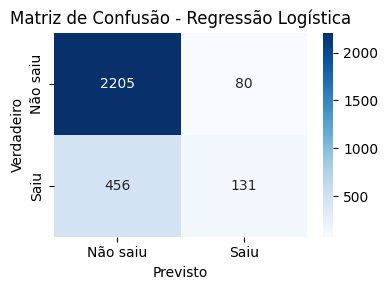


Modelo: Árvore de Decisão (Classificação)
Acurácia : 0.85
Precisão : 0.80
Recall   : 0.71
F1-Score : 0.74


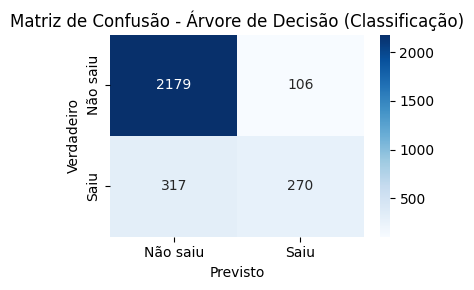


Modelo: Random Forest (Classificação)
Acurácia : 0.86
Precisão : 0.82
Recall   : 0.70
F1-Score : 0.73


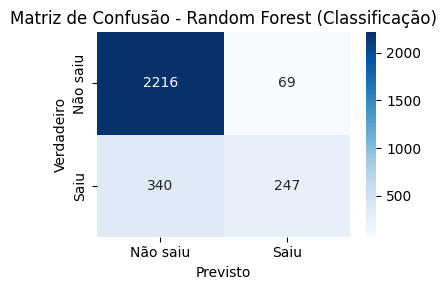


Modelo: SVM (Classificação)
Acurácia : 0.80
Precisão : 0.90
Recall   : 0.52
F1-Score : 0.48


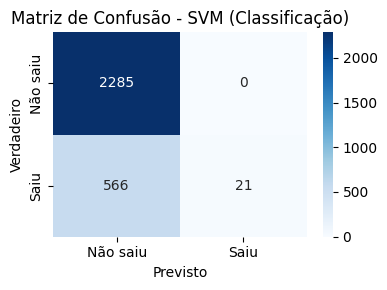


Modelo: K-NN (Classificação)
Acurácia : 0.80
Precisão : 0.69
Recall   : 0.59
F1-Score : 0.60


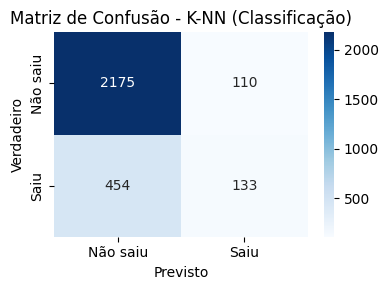

In [7]:

modelos_classificacao = {
    "Regressão Logística": LogisticRegression(
        C=0.8,                    # Reduzi o C para aumentar levemente a regularização, buscando um modelo mais simples e com menor risco de overfitting
    ),

    "Árvore de Decisão (Classificação)": DecisionTreeClassifier(
        max_depth=8,              # Definindo um limite pra arvore não crescer muito e criar um overfitting
        min_samples_leaf=15,      # Exigi que cada folha final tenha no mínimo 15 amostras, tornando as decisões do modelo mais robustas
    ),

    "Random Forest (Classificação)": RandomForestClassifier(
        n_estimators=200,         # Aumentei o número de árvores para buscar um modelo mais estável
    ),

    "SVM (Classificação)": SVC(
        C=1.2,                    # Aumentei o C para diminuir levemente a regularização, para se ajustar um pouco mais aos dados
    ),

    "K-NN (Classificação)": KNeighborsClassifier(
        n_neighbors=9,            # Escolhi 9 vizinhos, um número ímpar para evitar empates, buscando um equilíbrio entre viés e variância
    )
}

# Testando modelos de classificação
# Feito com base na aula 10

# For dos modelos de classificação
for nome, modelo in modelos_classificacao.items():
    modelo.fit(X_train_clf, y_train_clf)
    y_pred = modelo.predict(X_test_clf)

    print(f"\nModelo: {nome}")

    acc = accuracy_score(y_test_clf, y_pred)
    prec = precision_score(y_test_clf, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test_clf, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_clf, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test_clf, y_pred)

    print(f"Acurácia : {acc:.2f}")
    print(f"Precisão : {prec:.2f}")
    print(f"Recall   : {rec:.2f}")
    print(f"F1-Score : {f1:.2f}")

    # Matriz de confusão
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()




Modelo: Regressão Linear
Mean Squared Error (MSE): 0.0464
R2 Score: 0.2394


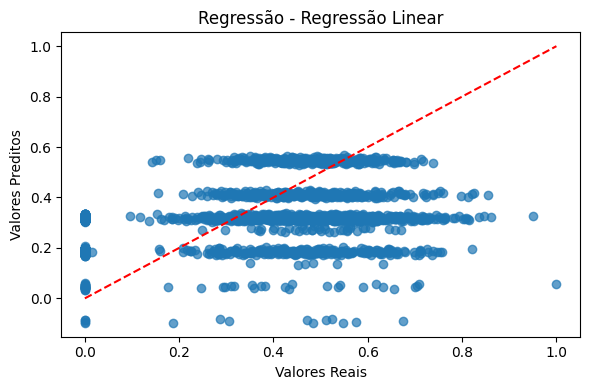


Modelo: Árvore de Regressão
Mean Squared Error (MSE): 0.0520
R2 Score: 0.1474


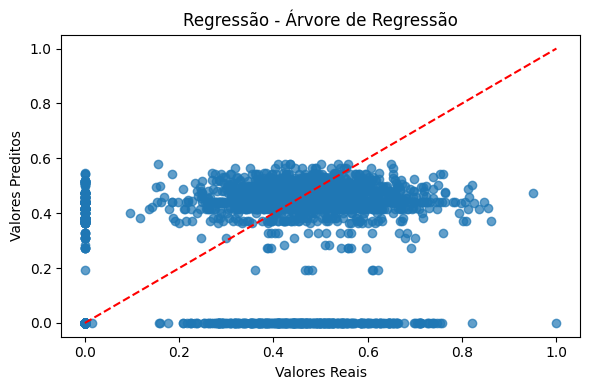


Modelo: Random Forest Regressor
Mean Squared Error (MSE): 0.0415
R2 Score: 0.3185


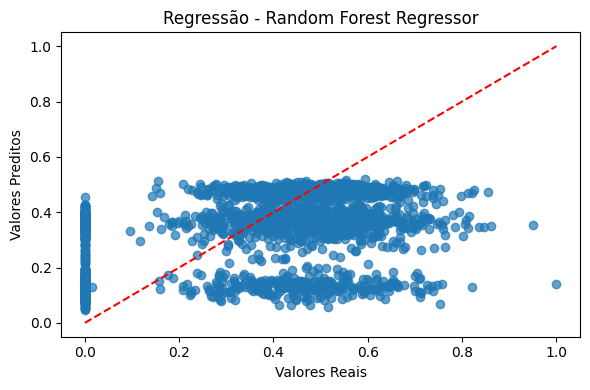


Modelo: Support Vector Regressor
Mean Squared Error (MSE): 0.0461
R2 Score: 0.2438


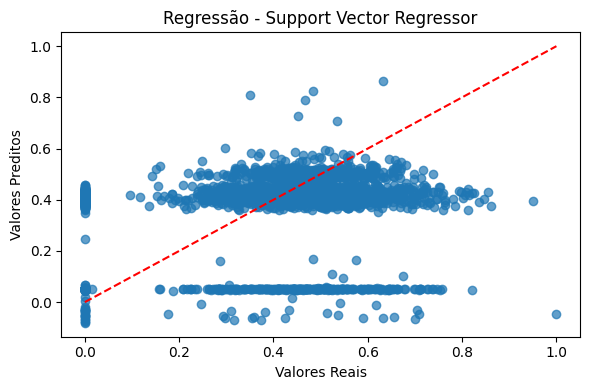

In [23]:
modelos_regressao = {
    "Regressão Linear": LinearRegression(
    ),

    "Árvore de Regressão": DecisionTreeRegressor(
        max_depth=8,                 # Barrei o crescimento excessivo para evitar
        min_samples_leaf=20,         # Pelo tamanho do modelo testei com um minimo definido de previsões por ciclo
        random_state=42
    ),

    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=200,            # Aumentei para tentar consegui uma melhor performance
        max_depth=10,                # Limitei a profundidade para evitar overfitting
        min_samples_leaf=15,         # Dei um minimo de samples leaf para aproveitar mais da base em cada ciclo
        random_state=42
    ),

    "Support Vector Regressor": SVR(
        C=1.5,                       # Tentei melhorar os ajustes finos do modelo
    )
}

# For dos modelos de regressão
for nome, modelo in modelos_regressao.items():
    modelo.fit(X_train_reg, y_train_reg)
    y_pred = modelo.predict(X_test_reg)

    print(f"\nModelo: {nome}")

    mse = mean_squared_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Gráfico real x previsto
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_reg, y_pred, alpha=0.7)
    plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Preditos")
    plt.title(f"Regressão - {nome}")
    plt.tight_layout()
    plt.show()

# **Ranking dos modelos de classificação**

**Árvore de Decisão**

Apresentou o melhor desempenho geral, com alta acurácia e o maior F1-Score, indicando o melhor equilíbrio entre não dizer que clientes que não sairam, deixaram o banco (precisão) e conseguir identificar corretamente os que de fato saem (recall). F1-Score = 0.74

-------------------------------------------------------------------

**Random Forest**

Desempenho quase idêntico ao da Árvore de Decisão, com a maior acurácia (0.86), mas um F1-Score ligeiramente inferior. Continua sendo uma escolha excelente e muito robusta. F1-Score = 0.73

-------------------------------------------------------------------

**Regressão Logística**

Embora sua acurácia seja menor que a do SVM, seu F1-Score é consideravelmente melhor, indicando um desempenho mais equilibrado.
F1-Score = 0.61

-------------------------------------------------------------------

**KNN**

Resultado muito similar ao da Regressão Logística, mostrando um equilíbrio razoável.
F1-Score = 0.60

-------------------------------------------------------------------

**SVM**

Apesar da precisão altíssima (0.90), o recall muito baixo (0.52) prejudica drasticamente seu F1-Score, tornando-o o modelo menos balanceado e menos útil para o problema como um todo. F1-Score = 0.48

-------------------------------------------------------------------

#**Ranking dos modelos de Regressão**

**Random Forest Regressor**

É o campeão indiscutível, pois comete os menores erros e é o que melhor consegue explicar a variação do saldo em conta.

MSE = 0.0415 (menor de todos); R2 Score = 0.3185 (maior de todos).

-------------------------------------------------------------------
**SVR**

Apresenta o segundo melhor desempenho, superando a Regressão Linear tanto no erro quanto na capacidade de explicação

MSE = 0.0461; R2 Score = 0.2438.

-------------------------------------------------------------------

**Regressão Linear**

Um resultado bom, servindo como uma boa linha de base, mas foi superado pelo SVR e pelo Random Forest

MSE = 0.0464; R2 Score = 0.2394.

------

Árvore de Regressão

MSE = 0.0520 (Maior erro); R2 Score = 0.1474 (Menor).

Teve o pior desempenho geral, com os maiores erros e a menor capacidade de explicar os dados, com metade do Random Forest Regressor em R2, o que mostrou a superioridade do conjunto de árvores.


# **Defesa da Escolha de Hiperparâmetros**

**Regressão Logística:**

Para a Regressão Logística, o parâmetro C foi definido como 0.8 para aumentar levemente a regularização, buscando um modelo mais simples e com menor risco de overfitting.

---

**Árvore de Decisão:**

Na Árvore de Decisão de Classificação, o max_depth foi limitado em 8 para que a árvore não crescesse excessivamente e criasse overfitting. Além disso, o min_samples_leaf foi definido como 15, tornando as decisões do modelo mais robustas.

---

**Random Forest:**

No Random Forest de Classificação, o n_estimators foi ajustado para 200 para buscar um modelo mais estável.

---

**SVM:**
Para o SVM de Classificação, o parâmetro C foi aumentado para 1.2 para diminuir levemente a força da regularização, permitindo que o modelo se ajustasse um pouco mais aos dados de treino.

**K-NN:**
No K-NN, o n_neighbors foi definido como 9, um número ímpar que evita empates e busca um bom equilíbrio entre viés e variância.

**Árvore de Regressão:**
Para a Árvore de Regressão, o max_depth foi limitado em 8 para barrar o crescimento excessivo e evitar o overfitting. Também foi definido um min_samples_leaf de 20 para testar o modelo com um número mínimo de previsões por ciclo.

**Random Forest Regressor:**
No Random Forest Regressor, o n_estimators foi aumentado para 200 na tentativa de conseguir uma melhor performance. O max_depth foi limitado em 10 para evitar overfitting e o min_samples_leaf foi definido como 15 para aproveitar mais da base de dados em cada ciclo.

**SVR**
No Support Vector Regressor, o parâmetro C foi ajustado para 1.5 para melhorar os ajustes finos do modelo.
